In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# <center><b>WebScrapping from kolesa.kz</b></center>

In [2]:
driver = webdriver.Chrome()  

In [3]:
city = 'astana'
car_company = 'toyota'
car_model = 'camry'
start_year = 2019

In [4]:
url = f'https://kolesa.kz/cars/{car_company}/{car_model}/{city}/?year%5Bfrom%5D={start_year}'

In [5]:
driver.get(url)

In [6]:
time.sleep(5)

In [7]:
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'a-card__info')))

<selenium.webdriver.remote.webelement.WebElement (session="1fdcf426ac8ef331a9ddbd55d9e64e60", element="f.941A55A46153814A8B4EF3E805607FFC.d.EDD2E4BF5831C8DCA13003D06A98C109.e.150")>

In [8]:
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [9]:
car_listings = soup.find_all('div', class_='a-card')

In [10]:
driver.get(url)
soup = BeautifulSoup(driver.page_source, 'html.parser')

pagination_links = soup.select('a[href*="page="]')
pages = []
for link in pagination_links:
    text = link.get_text(strip=True)
    try:
        pages.append(int(text))
    except ValueError:
        continue

max_page = max(pages) if pages else 1
print("max page:", max_page)

max page: 23


In [11]:
cars = []

for page in range(1, max_page):  
    url = f'https://kolesa.kz/cars/{car_company}/{car_model}/{city}/?year%5Bfrom%5D={start_year}&page={page}'
    driver.get(url)

    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CLASS_NAME, 'a-card__link'))
    )

    soup = BeautifulSoup(driver.page_source, 'html.parser')

    listings = soup.find_all('div', class_='a-list__item')

    for item in listings:
        
        header = item.find('div', class_='a-card__header')
        if header:
            title_elem = header.find('h5', class_='a-card__title')
            if title_elem:
                link_elem = title_elem.find('a', class_='a-card__link')
        price_elem = item.find('span', class_='a-card__price')
        desc_elem = item.find('p', class_='a-card__description')

        if title_elem and price_elem and desc_elem:
            title = title_elem.text.strip()
            price = price_elem.text.strip().replace('\xa0', ' ')
            description = desc_elem.text.strip()
            link = 'https://kolesa.kz' + link_elem['href'] if link_elem and link_elem.has_attr('href') else None


            cars.append({
                'Title': title,
                'Price': price,
                'Description': description,
                'URL': url
            })

    time.sleep(2)

# <center><b>Explaratory Data Analysis</b></center>

In [12]:
df = pd.DataFrame(cars)

df['Year'] = df['Description'].str.extract(r'(\d{4}) г\.')
df['Condition'] = df['Description'].str.extract(r'(Б/у|новый)')
df['Car Type'] = df['Description'].str.extract(r'(седан|внедорожник|купе|хэтчбек|универсал|кроссовер)')
df['Engine Size (L)'] = df['Description'].str.extract(r'(\d\.\d) л')
df['Fuel Type'] = df['Description'].str.extract(r'(бензин|дизель|газ|гибрид|электро)')
df['Transmission'] = df['Description'].str.extract(r'(КПП автомат|КПП механика|КПП вариатор|АКПП|МКПП)')
df['Mileage (km)'] = df['Description'].str.extract(r'с пробегом ([\d\s]+) км')

df['Condition'] = df['Condition'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['Car Type'] = df['Car Type'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['Fuel Type'] = df['Fuel Type'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['Transmission'] = df['Transmission'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['Mileage (km)'] = df['Mileage (km)'].str.replace(' ', '').fillna('0').astype(int)

df.drop('Description', axis=1, inplace=True) #becomes useless

condition_mapping = {
    "Б/у": "Used",
    "новый": "New"
}

car_type_mapping = {
    "седан": "Sedan",
    "внедорожник": "SUV",
    "купе": "Coupe",
    "хэтчбек": "Hatchback",
    "универсал": "Station Wagon",
    "кроссовер": "Crossover"
}

fuel_mapping = {
    "бензин": "Gasoline",
    "дизель": "Diesel",
    "газ": "Gas",
    "гибрид": "Hybrid",
    "электро": "Electric"
}

transmission_mapping = {
    "КПП автомат": "Automatic",
    "КПП механика": "Manual",
    "КПП вариатор": "CVT",
    "АКПП": "Automatic",
    "МКПП": "Manual"
}

Applying mapping:

In [13]:
df['Condition'] = df['Condition'].map(condition_mapping)
df['Car Type'] = df['Car Type'].map(car_type_mapping)
df['Fuel Type'] = df['Fuel Type'].map(fuel_mapping)
df['Transmission'] = df['Transmission'].map(transmission_mapping)

df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Engine Size (L)'] = pd.to_numeric(df['Engine Size (L)'], errors='coerce')

df

,Title,Price,URL,Year,Condition,Car Type,Engine Size (L),Fuel Type,Transmission,Mileage (km)
0,Toyota Camry,12 850 000 ₸,https://kolesa.kz/cars/toyota/camry/astana/?ye...,2022,Used,Sedan,2.5,Gasoline,Automatic,122010
1,Toyota Camry,13 370 000 ₸,https://kolesa.kz/cars/toyota/camry/astana/?ye...,2020,Used,Sedan,2.5,Gasoline,Automatic,116366
2,Toyota Camry,14 440 000 ₸,https://kolesa.kz/cars/toyota/camry/astana/?ye...,2021,Used,Sedan,2.5,Gasoline,Automatic,47379
3,Toyota Camry,13 580 000 ₸,https://kolesa.kz/cars/toyota/camry/astana/?ye...,2021,Used,Sedan,2.5,Gasoline,Automatic,49509
4,Toyota Camry,15 000 000 ₸,https://kolesa.kz/cars/toyota/camry/astana/?ye...,2019,Used,Sedan,2.5,Gasoline,Automatic,92000
...,...,...,...,...,...,...,...,...,...,...
435,Toyota Camry,19 000 000 ₸,https://kolesa.kz/cars/toyota/camry/astana/?ye...,2023,Used,Sedan,2.5,Gasoline,Automatic,12000
436,Toyota Camry,14 500 000 ₸,https://kolesa.kz/cars/toyota/camry/astana/?ye...,2019,Used,Sedan,2.5,Gasoline,Automatic,64000
437,Toyota Camry,15 400 000 ₸,https://kolesa.kz/cars/toyota/camry/astana/?ye...,2019,Used,Sedan,2.5,Gasoline,Automatic,66000
438,Toyota Camry,16 800 000 ₸,https://kolesa.kz/cars/toyota/camry/astana/?ye...,2023,Used,Sedan,2.5,Gasoline,Automatic,43000


In [14]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce', downcast='integer')
df['Price'] = df['Price'].str.replace(r'\D+', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce', downcast='integer')
df['Engine Size (L)'] = pd.to_numeric(df['Engine Size (L)'], errors='coerce')
df['Mileage (km)'] = pd.to_numeric(df['Mileage (km)'], errors='coerce', downcast='integer')
df['Engine Size (L)'] = df['Engine Size (L)'].astype('category')

In [15]:
df.columns

Index(['Title', 'Price', 'URL', 'Year', 'Condition', 'Car Type',
       'Engine Size (L)', 'Fuel Type', 'Transmission', 'Mileage (km)'],
      dtype='object')

In [16]:
df.dtypes

Title                object
Price                 int32
URL                  object
Year                  int16
Condition            object
Car Type             object
Engine Size (L)    category
Fuel Type            object
Transmission         object
Mileage (km)          int32
dtype: object

In [17]:
print(df.isnull().sum()) #missing values per column

Title               0
Price               0
URL                 0
Year                0
Condition           0
Car Type            0
Engine Size (L)    37
Fuel Type           0
Transmission        0
Mileage (km)        0
dtype: int64


#### Extracting engine size from the Title (if "2.5" or "3.5" is mentioned)

In [18]:
def impute_engine_from_title(row):
    if pd.isna(row['Engine Size (L)']):
        title = row['Title'].lower()
        if '2.5' in title:
            return 2.5
        elif '3.5' in title:
            return 3.5
    return row['Engine Size (L)']

df['Engine Size (L)'] = df.apply(impute_engine_from_title, axis=1)


In [19]:
mode_engine = df['Engine Size (L)'].mode()[0]
df['Engine Size (L)'] = df['Engine Size (L)'].fillna(mode_engine)


In [20]:
print(df.isnull().sum()) #missing values per column

Title              0
Price              0
URL                0
Year               0
Condition          0
Car Type           0
Engine Size (L)    0
Fuel Type          0
Transmission       0
Mileage (km)       0
dtype: int64


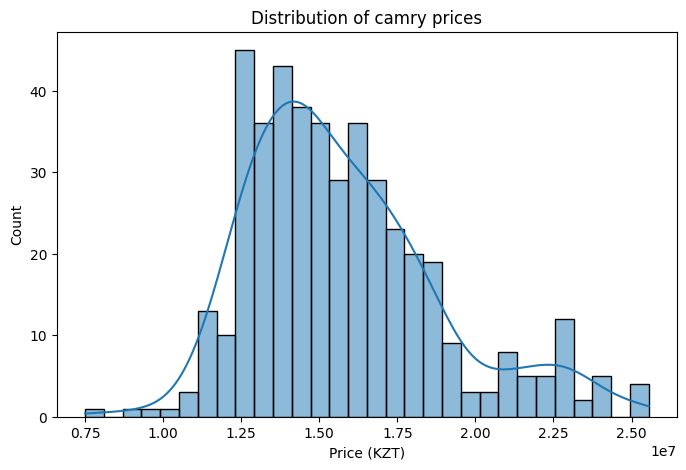

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title(f'Distribution of {car_model} prices')
plt.xlabel('Price (KZT)')
plt.ylabel('Count')

plt.show()

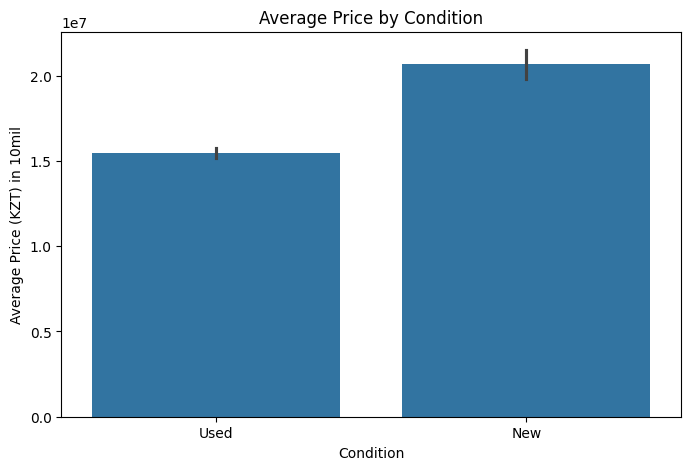

In [22]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Condition', y='Price', estimator='mean')
plt.title('Average Price by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Price (KZT) in 10mil')
plt.show()


In [23]:
print(df.shape)
print(df[['Mileage (km)', 'Price']].dropna().shape)

(440, 10)
(440, 2)


In [24]:
print(df['Mileage (km)'].isna().sum())
print(df['Price'].isna().sum())

0
0


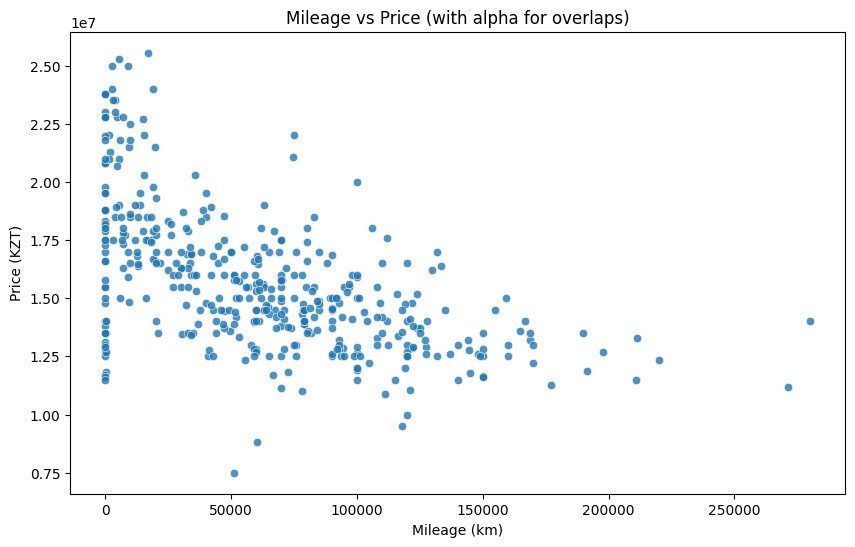

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Mileage (km)', y='Price', alpha=0.8)
plt.title('Mileage vs Price (with alpha for overlaps)')
plt.xlabel('Mileage (km)')
plt.ylabel('Price (KZT)')
plt.show()
